In [74]:
import time
from datetime import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
%matplotlib inline

In [115]:
## Import data
training_filename = 'dtrain123.dat'
test_filename = 'dtest123.dat'
filename = 'zipcombo.dat'
data = np.loadtxt(filename)
## define feature vector x and true value y
x = data[:,1:]
y = data[:,0]

In [76]:
def Polynomial_Kernel(x1,x2,d):
    """
    Constructions the polynomial kernel matrix of order d
    :param x1: the first set of observations
    :param x2: the second set of observations
    :param d: the order of polynomial
    :return: the polynomial kernel
    """
    K = (x1 @ x2.T)**d
    return K

In [77]:
def Gaussian_Kernel(A,B,c):
    """
    A: a*n matrix
    B: b*n matrix, where 'a' may equal to 'b'
    Distance: the pairwise distances a*b matrix
    c: the constant scale of the exponential factor
    return: the kernel matrix K
    """
    p1 = np.sum(A**2,axis=1)[:,np.newaxis]
    p2 = np.sum(B**2,axis=1)
    p3 = -2*np.dot(A,B.T)
    Distances = p1+p2+p3
    K = np.exp(-c*Distances)
    return K 

In [78]:
# define function to calculate K(xi,xt) in training since 2 kernel is considered
def train_kernel(x,d,kernel_choice):
    """
    parameter
    -----------------------
    x: train set, feature matrix
    d: dimension
    kernel_choice: polynomial or Gaussian
    return : kernel trick used in training x
    """
    if kernel_choice=='Polynomial':
        K_train = Polynomial_Kernel(x,x,d)
    else:
        K_train = Gaussian_Kernel(x,x,c=d)
    return K_train

In [79]:
def test_kernel(x1,x2,d,kernel_choice):
    """
    Calculates the kernel function of matrix x1 and x2.
    :param x1: the first matrix x1
    :param x2: the first matrix x2
    :param d: is either the order of the polynomial kernel or the constant in the gaussian kernel
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :return: the kernel matrix
    """
    if kernel_choice=='Polynomial':
        K_test = Polynomial_Kernel(x1,x2,d)
    else:
        kernel_choice=='Gaussian'
        K_test = Gaussian_Kernel(x1,x2,c=d)
    return K_test

In [80]:
def perceptron_epoch(x, y, alpha, K_train):
    """
    Given a set of weights alpha, this function goes through the whole set of examples in x, one by one
    and iteratively update the weights if a mistake has happened.
    :param x: the observations array
    :param y: the labels vector
    :param y_arr: the transformed labels matrix
    :param alpha: the set of weights
    :param K_train: the kernel matrix as calculated over x
    :return: the updated weights alpha and the number of errors made while going through the points
    """
    # Number of examples
    m = x.shape[0] 
    num_errors = 0

    for t in range(m):
        # Find our training set
        x_t = x[t,:] #n size (1,10)
        y_t = y[t]
        # pred_t computes \sum^{t-1}_{i=0} {(alpha_i K(x_t, x_i))}, 
        # which is regarded as the confidence in each class
        confidence = alpha.T @K_train[t,:]
        
        for index in range(len(confidence)):
            if (confidence[index]>0):
                if index!= y_t:
                    num_errors+=1
                    alpha[t][index]+=-1
            if (confidence[index]<=0):
                if index == y_t:
                    num_errors+=1
                    alpha[t][index]+=1
            
            # Store alpha_t into the matrix for future reference
    return alpha, num_errors

In [81]:
# One vs. rest: train k classifiers to identify k classes
def perceptron_train(x, y, d, kernel_choice='Polynomial', convergence_threshold=0.01):
    """
    Trains a perceptron based on the one vs. rest approach, i.e. train k classifiers to identify k classes
    :param x: the observations array
    :param y: the labels vector
    :param d: is either the order of the polynomial kernel or the constant in the gaussian kernel
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :param convergence_threshold: the threshold value upon we stop updating the perceptron, if the difference
    in errors was smaller than that
    :return:
    """
    m = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    classes_num = 10 #number of classes 
     
    error_per_epoch = []
    alpha = np.zeros((m,classes_num)) #Need to store alpha array at all iteration, as we need it to compute confidence
    
    K_train = train_kernel(x, d, kernel_choice)    
    epochs = 0
    while True:
        alpha, num_errors = perceptron_epoch(x, y, alpha, K_train)
        
        error_rate_current = error_per_epoch[-1] / x.shape[0] if epochs > 0 else 0
        error_rate_next = num_errors / x.shape[0]

        error_per_epoch.append(num_errors)
        if epochs > 0 and (error_rate_next > error_rate_current or \
            error_rate_current - error_rate_next < convergence_threshold):
            break
            
        epochs += 1

    return alpha, error_per_epoch

In [82]:
def perceptron_test(x_test,x_train,y_test, alphas, d, kernel_choice='Polynomial'):
    """
    This function predicts the labels for a given set of observations.
    :param x_test: the set of observations to predict
    :param x_train: the observations in which the perceptron has been trained on
    :param y_test: the true labels of x_test
    :param alphas: the set of weights of the perceptron
    :param d: is either the order of the polynomial kernel or the constant in the gaussian kernel
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :return: the number of mistakes that the perceptron made, the predictions as well as the confidence values.
    """
    # Calculate the Kernel matrix
    K_test = test_kernel(x_train, x_test, d, kernel_choice)
    
    # Compute the confidence
    confidence = (alphas.T @ K_test).T
    
    # Compute mistakes and predictions
    preds = np.zeros(confidence.shape)
    mistakes = 0
    for i in range(y_test.shape[0]):
        y_hat = confidence[i].argmax()
        preds[i,y_hat] = 1
        if y_hat != y_test[i]:
            mistakes += 1
            
    return mistakes, preds, confidence

## Q1 Basic Results of Polynomial Kernel

In [71]:
def basic_results(data,d_arr, kernel_choice, runs):
    """
    For every value in d_arr, and using the kernel specified in kernel_choice,
    it performs "runs" iterations where it trains a perceptron based on randomly selected
    80% of the data and tests on the rest 20%.
    :param d_arr: an array of d values
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :param runs: the number of runs to perform
    :return: two arrays: one containing the errors recorded in the training set in every run and one for the test set.
    """
    X = data[:,1:]
    y = data[:,0]
    training_set_errors = np.zeros((len(d_arr),runs))
    test_set_errors = np.zeros((len(d_arr),runs))
    
    for d in d_arr:
        for i in range(runs):
            print("Now doing run ", i+1, "/", runs, " for d=", d,".........", end='\r')
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
            alphas,_ = perceptron_train(X_train, y_train, d, kernel_choice=kernel_choice)
            # get training error and test error
            train_errors,_,_ = perceptron_test(X_train, X_train, y_train, alphas, d, kernel_choice=kernel_choice)
            test_errors,_,_ = perceptron_test(X_test, X_train, y_test, alphas, d, kernel_choice=kernel_choice)

            training_set_errors[d-1, i] = train_errors / y_train.shape[0]
            test_set_errors[d-1, i] = test_errors / y_test.shape[0]
    return training_set_errors, test_set_errors

In [28]:
d_arr = np.arange(1,8)
runs = 20
startTime = datetime.now()
training_set_errors, test_set_errors = basic_results(data,d_arr, 'Polynomial', runs)
Part1_Q1 = datetime.now() - startTime
print("\nTime taken: ", Part1_Q1)

Now doing run  20 / 20  for d= 7 .........
Time taken:  0:14:07.533529


In [29]:
def construct_table(training_set_errors,test_set_errors):
    train_mean=np.mean(training_set_errors,axis=1)
    train_std=np.std(training_set_errors,axis=1)
    test_mean=np.mean(test_set_errors,axis=1)
    test_std=np.std(test_set_errors,axis=1)

    mean_std = []
    for i in range(len(train_mean)):
        data_t = []
        colomn_1 = "{0:.4f} +- {1:.4f}".format(train_mean[i]*100,train_std[i]*100)
        
        data_t.append(colomn_1)
        colomn_2 = "{0:.4f} +- {1:.4f}".format(test_mean[i]*100,test_std[i]*100) 
        
        data_t.append(colomn_2)
        mean_std.append(data_t)
    return mean_std

# to construct table
d_arr = np.arange(1,8)
mean_std=construct_table(training_set_errors,test_set_errors)
pd.DataFrame(data=mean_std,index=d_arr,columns=['train_mean_std(%)','test_mean_std(%)'])

,train_mean_std(%),test_mean_std(%)
1,7.5867 +- 1.5759,9.5403 +- 1.5621
2,0.7065 +- 0.3968,3.6909 +- 0.5596
3,0.1828 +- 0.0894,3.2070 +- 0.3963
4,0.1102 +- 0.0892,2.9543 +- 0.2832
5,0.1418 +- 0.3603,2.9758 +- 0.5591
6,0.0437 +- 0.0272,2.8548 +- 0.3562
7,0.0383 +- 0.0177,2.9624 +- 0.3309


## Q2 Add Cross Validation

In [105]:
# 20 runs , 1 d, train one cv.
def cross_validation(x, y,d,kernel_choice,k):
    """
    This function performs a k-fold cross validation on X, using a kernel of "kernel_choice" with parameter d.
    :param X: the observations array
    :param y: the labels vector
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :param d: the parameter of the kernel
    :param k: the number of splits, i.e. the k parameter in k-fold Cross Validation
    :return: the mean of test error across the k runs of the CV process and its standard deviation
    """
    kf = KFold(n_splits=k, shuffle=True)
    mistake_arr = np.zeros(k)
    i = 0
    
    for train_index, cv_index in kf.split(x):
        # Spit the matrix using the indices gained by the CV method and construct X and Y arrays
        X_train = x[train_index]
        X_cv = x[cv_index]
        y_train = y[train_index]
        y_cv = y[cv_index]
    
        # We are only interested in the alphas and not the MSE on the training set
        alphas, errors = perceptron_train(X_train, y_train, d, kernel_choice = kernel_choice)
        mistakes,_,_ = perceptron_test(X_cv, X_train, y_cv, alphas, d, kernel_choice = kernel_choice)
        mistake_arr[i] = mistakes / len(y_cv)
        i += 1
        
    return mistake_arr.mean()

In [106]:
def cv_process(d_arr, runs, kernel_choice,x,y):
    """
    This function performs 5-fold cross validation, multiple times (specified by runs argument) across the different
    values of d specified in d_arr using the kernel specified in kernel_choice
    :param d_arr: an array of d values
    :param runs: The number of runs to repeat the CV process
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :param calculate_confusions: Whether or not to also calculate confusions on the test set
    :return: the array of d_stars, the test_errors and the confusions found
    """
    d_stars = np.zeros(runs)
    test_errors = np.zeros(runs)
#     confusion_mtx_list = []
    for run in range(runs):
        single_confusion_mtx = np.zeros(shape = (10,10))
        # In each run we will iterate through the d array and use all possible values of d
        # Allocate 80/20 percent for training and test set
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

        CV_means = np.zeros(len(d_arr))
        for i in range(len(d_arr)):
            print("Now doing run ", run+1, "/", runs, " for d=", d_arr[i], ".........", end='\r')
            mistake = cross_validation(X_train, y_train,d_arr[i],kernel_choice, k=5)
            CV_means[i] = mistake
            
        # Train in whole 80% now with d_star
        d_stars[run] = d_arr[CV_means.argmin()]
        alphas, errors = perceptron_train(X_train, y_train, d_stars[run], kernel_choice = kernel_choice)

        mistakes,preds_test,_ = perceptron_test(X_test, X_train, y_test, alphas, d_stars[run], kernel_choice = kernel_choice)
        test_errors[run] = mistakes / len(y_test)
        
    return d_stars,test_errors 

In [111]:
runs = 20
startTime = datetime.now()
P_d_stars_array, P_test_errors_array = cv_process(d_arr, runs, 'Polynomial',x,y)
time_OVA_cv = datetime.now() - startTime
print("Time taken: ", time_OVA_cv)
print("Mean d*: ", P_d_stars_array.mean(), " with std: ", np.std(P_d_stars_array))
print("Mean test error(%): ", P_test_errors_array.mean()*100, " with std(%): ", np.std(P_test_errors_array)*100)

Time taken:  0:34:02.583907 d= 7 .........
Mean d*:  5.4  with std:  0.8602325267042626
Mean test error(%):  2.9892473118279574  with std(%):  0.4190100595354562


## Confusion Martix

In [103]:
single_confusion_mtx_list = []
d_arr = np.arange(1,8)
d_stars = np.zeros(20)

for run in range(20):
    single_confusion_mtx = np.zeros(shape = (10,10))
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
    
    CV_means = np.zeros(len(d_arr))
    for i in range(len(d_arr)):
        print("Now doing run ", run, "/", run, " for d=", d_arr[i], ".........", end='\r')
        MSE_CV_mean = cross_validation(X_train, y_train, d_arr[i],kernel_choice='Polynomial',k=5)
        CV_means[i] = MSE_CV_mean

    # Train in whole 80% now with d_star
    d_stars[run] = d_arr[CV_means.argmin()]
    alphas, errors = perceptron_train(X_train, y_train, d_stars[run], kernel_choice = 'Polynomial')
    mistakes,preds_test,_ = perceptron_test(X_test, X_train, y_test, alphas, d_stars[run], kernel_choice = 'Polynomial')

    for i in range(X_test.shape[0]):
        # 每一行中最大的数的index，要和true class of y 进行比较
        pred_label = preds_test[i].argmax()
        if preds_test[i].argmax() != y_test[i]:
            single_confusion_mtx[int(y_test[i]),int(pred_label)]+=1
    single_confusion_mtx_list.append(single_confusion_mtx)  

In [104]:
confusions_matrix = []
for i in range(10):
    confusions_i = []
    for j in range(10):
        confusions_ij = np.asarray([single_confusion_mtx_list[r][i,j] for r in range(20)])
        confusions_i.append("{0:.2f} +- {1:.2f}".format(confusions_ij.mean()*100, np.std(confusions_ij)*100))
    confusions_matrix.append(confusions_i)
    
df = pd.DataFrame(data=confusions_matrix)
df = df.style.set_properties(**{'font-size':'8pt'})
df

,0,1,2,3,4,5,6,7,8,9
0,0.00 +- 0.00,30.00 +- 45.83,60.00 +- 91.65,50.00 +- 92.20,45.00 +- 58.95,40.00 +- 58.31,75.00 +- 94.21,15.00 +- 35.71,30.00 +- 45.83,40.00 +- 58.31
1,0.00 +- 0.00,0.00 +- 0.00,20.00 +- 40.00,5.00 +- 21.79,70.00 +- 78.10,0.00 +- 0.00,45.00 +- 66.90,10.00 +- 30.00,25.00 +- 43.30,10.00 +- 43.59
2,50.00 +- 80.62,30.00 +- 45.83,0.00 +- 0.00,80.00 +- 67.82,135.00 +- 101.37,20.00 +- 50.99,30.00 +- 55.68,70.00 +- 64.03,105.00 +- 92.06,15.00 +- 35.71
3,30.00 +- 55.68,30.00 +- 55.68,120.00 +- 107.70,0.00 +- 0.00,35.00 +- 57.23,335.00 +- 224.22,0.00 +- 0.00,85.00 +- 101.37,180.00 +- 132.66,30.00 +- 45.83
4,15.00 +- 35.71,110.00 +- 83.07,100.00 +- 77.46,15.00 +- 35.71,0.00 +- 0.00,50.00 +- 86.60,65.00 +- 85.29,45.00 +- 58.95,10.00 +- 30.00,180.00 +- 124.90
5,100.00 +- 94.87,15.00 +- 35.71,55.00 +- 58.95,135.00 +- 106.18,85.00 +- 96.31,0.00 +- 0.00,135.00 +- 135.19,10.00 +- 30.00,80.00 +- 97.98,50.00 +- 67.08
6,125.00 +- 94.21,50.00 +- 92.20,45.00 +- 66.90,5.00 +- 21.79,60.00 +- 86.02,55.00 +- 58.95,0.00 +- 0.00,0.00 +- 0.00,25.00 +- 53.62,5.00 +- 21.79
7,0.00 +- 0.00,45.00 +- 92.06,30.00 +- 45.83,5.00 +- 21.79,150.00 +- 156.52,15.00 +- 35.71,0.00 +- 0.00,0.00 +- 0.00,65.00 +- 72.63,140.00 +- 115.76
8,105.00 +- 107.12,80.00 +- 74.83,115.00 +- 90.97,195.00 +- 146.54,95.00 +- 80.47,170.00 +- 130.77,50.00 +- 92.20,45.00 +- 58.95,0.00 +- 0.00,25.00 +- 43.30
9,30.00 +- 45.83,10.00 +- 30.00,35.00 +- 65.38,50.00 +- 74.16,175.00 +- 189.41,30.00 +- 55.68,5.00 +- 21.79,145.00 +- 128.35,10.00 +- 30.00,0.00 +- 0.00


## Gaussian Kernel

In [108]:
def basic_results(data,d_arr, kernel_choice, runs):
    """
    For every value in d_arr, and using the kernel specified in kernel_choice,
    it performs "runs" iterations where it trains a perceptron based on randomly selected
    80% of the data and tests on the rest 20%.
    :param d_arr: an array of d values
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :param runs: the number of runs to perform
    :return: two arrays: one containing the errors recorded in the training set in every run and one for the test set.
    """
    X = data[:,1:]
    y = data[:,0]
    training_set_errors = np.zeros((len(d_arr),runs))
    test_set_errors = np.zeros((len(d_arr),runs))
    
    for d in d_arr:
        for i in range(runs):
            print("Now doing run ", i+1, "/", runs, " for d=", d,".........", end='\r')
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
            alphas,_ = perceptron_train(X_train, y_train, d, kernel_choice=kernel_choice)
            # get training error and test error
            train_errors,_,_ = perceptron_test(X_train, X_train, y_train, alphas, d, kernel_choice=kernel_choice)
            test_errors,_,_ = perceptron_test(X_test, X_train, y_test, alphas, d, kernel_choice=kernel_choice)

            training_set_errors[d-1, i] = train_errors / y_train.shape[0]
            test_set_errors[d-1, i] = test_errors / y_test.shape[0]
    return training_set_errors, test_set_errors

In [109]:
d_arr = np.arange(1,8)
runs = 20

startTime = datetime.now()
g_training_set_errors, G_test_set_errors = basic_results(data,d_arr, 'Gaussian', runs)
Part1_Q5 = datetime.now() - startTime
print("\nTime taken: ", Part1_Q5)

Now doing run  20 / 20  for d= 7 .........
Time taken:  0:16:06.326975


In [110]:
# to construct table
d_arr = np.arange(1,8)
mean_std=construct_table(training_set_errors,test_set_errors)
pd.DataFrame(data=mean_std,index=d_arr,columns=['train_mean_std(%)','test_mean_std(%)'])

,train_mean_std(%),test_mean_std(%)
1,0.0013 +- 0.0040,6.7554 +- 0.5632
2,0.0000 +- 0.0000,6.9677 +- 0.4629
3,0.0013 +- 0.0040,7.0027 +- 0.5443
4,0.0034 +- 0.0058,6.8333 +- 0.6265
5,0.0034 +- 0.0072,7.1720 +- 0.6043
6,0.0013 +- 0.0040,8.4032 +- 0.4818
7,0.0027 +- 0.0069,10.3629 +- 0.6160


### add cross_validation

In [116]:
runs = 20
startTime = datetime.now()
d_stars_array, gk_test_errors_array= cv_process(d_arr, runs, 'Gaussian',x,y)
time_gk_cv = datetime.now() - startTime
print("Time taken: ", time_gk_cv)
print("Mean d*: ", d_stars_array.mean(), " with std: ", np.std(d_stars_array))
print("Mean test error(%): ", gk_test_errors_array.mean()*100, " with std(%): ", np.std(gk_test_errors_array)*100)

Time taken:  0:37:39.421615 d= 7 .........
Mean d*:  2.45  with std:  1.3219304066402287
Mean test error(%):  6.946236559139783  with std(%):  0.4801529798229272


## Q4 Five Hardest Digit to Find 

In [48]:
def plot_hardest_images(indices):
    """
    This helper function plots images in an 1x(len(indices)) grid of plots.
    :param indices: The indices of examples to plot (from array 'x')
    """
    plt.figure(figsize=(30,30))
    k = 1
    for i in indices:
        a1 = plt.subplot(1, len(indices), k)
        pixels = np.array(x[i], dtype='uint8')
        pixels = pixels.reshape((16, 16))
        plt.title("Real: {0}".format(y[i]))
        a1.imshow(pixels, cmap='gray')
        k+=1
        
def find_hardest_elements(x, y, d_star, runs, k_splits=5):
    """
    This function performs a number of runs over the data set in order to find the 5 images which are the most
    difficult to predict. The way this process is done is the following:
        - We perform a 5-fold split over the data set, dividing into 80% for training and 20% for testing
        - We use the mean d_star as calculated over 20 runs of CV in the data set, to train a perceptron on the 80%
          of the data set.
        - We predict the remaining 20% and we store the confidences we obtain in each split and run
    At the end of the process, we sort the confidences in ascending order and return the 5 first indices
    (i.e. the observations which were harder to predict)
    :param x: the observations array
    :param y: the labels vector
    :param d_star: the value of d to use while training the perceptron
    :param runs: the number of runs to perform
    :param k_splits: the number of splits to perform while generating the training/test sets.
    :return: the indices of the elements of x, that we predict the least confidence with
    """
    least_confidences = np.zeros(data.shape[0])
    
    for run in range(runs):
        print("Finding hardest elements, run ", run+1, "/", runs,".....", end='\r')
        
        # Split into 80%/20% for training and test set
        kf = KFold(n_splits=k_splits, shuffle=True)
        for train_index, test_index in kf.split(x):
            X_train = x[train_index]
            X_test = x[test_index]
            y_train = y[train_index]
            y_test = y[test_index]

            alphas,_ = perceptron_train(X_train, y_train, d_star)
            _, preds_test, confidences = perceptron_test(X_test, X_train, y_test, alphas, d_star)
            
            for i in range(X_test.shape[0]):
                pred_label = preds_test[i].argmax()
                least_confidences[test_index[i]] += confidences[i][int(y_test[i])] / 5
    
    least_confidences /= runs

    conf_indices = np.argsort(least_confidences)[:5]
    return conf_indices, np.sort(least_confidences)[:5]

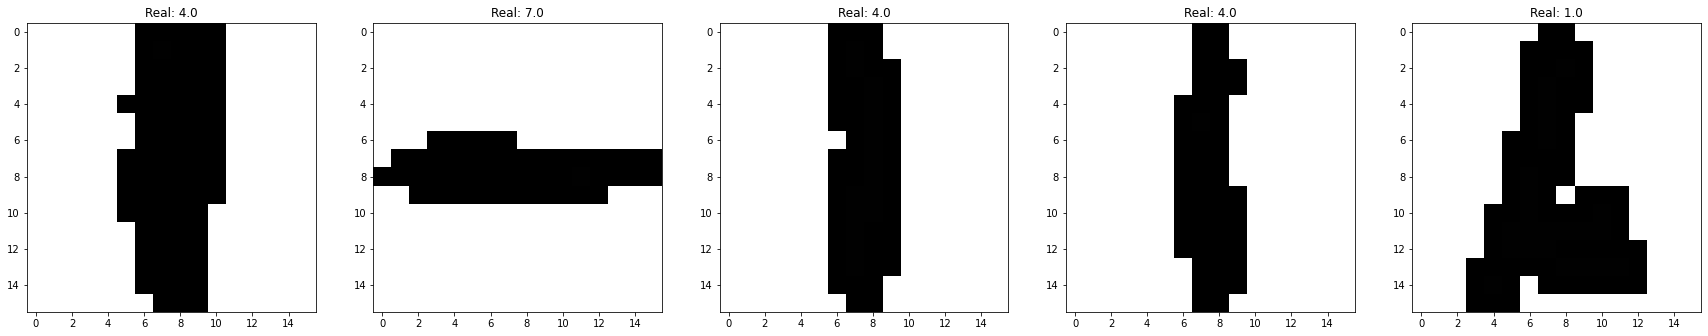

In [49]:
conf_indices, least_confidences = find_hardest_elements(x, y, int(d_stars_array.mean()), runs=20)
plot_hardest_images(conf_indices)

## One-vs-One Algorithm

In [54]:
def perceptron_train_ovo(x,y,d=2,kernel_choice='Polynomial', tol=0.01):
    """
    This function trains the classifiers needed for the one-versus-one approach of perceptron
    :param x: the observations array
    :param y: the labels vector
    :param d: the value of d used in the calculation of the kernel matrix
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :param tol: a threshold value which denotes the minimum change in error rate that we should have
    in order to continue training
    :return: a set of weights alpha (matrix of (m X n X n), where m is the number of examples,
    n is the number of classes) and the number of errors in the last epoch
    """
    m = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    classes_num = 10 #number of classes 
    max_epoch = 10 #the maximum number of epochs to perform while training the perceptrons
    error_per_epoch = np.zeros(max_epoch)
    errors = np.zeros(m)
    K_train = train_kernel(x, d, kernel_choice)
    alpha_mtx = np.zeros((m,classes_num,classes_num)) 
    
    for epoch in range(max_epoch):
        errors = np.zeros(m)
        num_errors = 0 #This should be bounded..? Maybe calculate the bound in the explanation
    
        #iterate through training set
        for t in range(m):
            if t==0:
                alpha_mtx_prev = alpha_mtx[0,:,:] #when t=0, the previous alpha is set to be 0
            else:
                alpha_mtx_prev = alpha_mtx[t-1,:,:] #

            x_t = x[t,:]
            y_t = y[t]

            votes_mtx = np.zeros((classes_num, classes_num)) #zero on the horizontal. 
            classes_list = np.array(range(classes_num))

            for i in range(classes_num):
                c1 = classes_list[i]
                classes_rest = classes_list[classes_list>c1]
                for j in range(len(classes_rest)):
                    c2 = classes_rest[j]
                    alpha_ovo = alpha_mtx[:,c1,c2]
#                   returns the signs denoting the votes of the one-versus-one classifier,(1,-1)
                    vote = np.sign(((alpha_ovo[:].T @K_train[t,:]).T))
                    #vote = classifier_ovo(c1,c2,K_train,alpha_ovo,iter_num=t)
                    votes_mtx[c1,c2] = vote

            #Count the votes in the matrix
            votes_count = votes_mtx.sum(axis=0) # sum every row
            pred_t = votes_count.argmax()

            if pred_t!=y_t:
                num_errors +=1
                alpha_t = alpha_mtx_prev #initialize it to its previous form
                alpha_t[:,int(y_t)] =+1 # column belonging to correct label class +=1
                alpha_t[:,int(pred_t)] =-1 # column belonging to false predicted class -=1

                #store alpha_t into the matrix for future reference
                alpha_mtx[t,:,:] = alpha_t
            
            errors[t] = num_errors 

        error_per_epoch[epoch] = errors[-1]
        
        if epoch>1:
            diff_rates = (error_per_epoch[epoch-1] - error_per_epoch[epoch])/m
            
            #Stop if the error rate has increased, 
            #or the difference in error rate between the previous one and the current one < tolerance. 
            if diff_rates<tol or diff_rates<0:
#                 print('difference in error rate', diff_rates)
#                 print('break point at epoch=', epoch )
                break
        
    return alpha_mtx, error_per_epoch[:epoch+1]

In [55]:
def perceptron_test_ovo(x_test,x_train,y_test,alpha_mtx, d,kernel_choice='Polynomial'):
    """
    This function predicts the label values of the examples found in x_test array using the one-versus-one perceptrons
    approach.
    :param x_test: a set of unseen examples that we wish to get predictions on
    :param x_train: the set of observations that the perceptrons have been trained on
    :param y_test: the true labels of x_test, used for calculating error rates
    :param alphas: the set of weights used for the perceptrons
    :param d: the value of d used in the calculation of the kernel matrix
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :return: the number of mistakes done on the test set as well as the actual predictions
    """
    m_test = x_test.shape[0]
    m_train = x_train.shape[0]
    
    K_test = test_kernel(x_train, x_test, d, kernel_choice)
    
    classes_num = 10
    classes_list = np.array(range(classes_num))
    votes_mtx =np.zeros((m_test,10,10))
    
    for i in range(classes_num):
        c1 = classes_list[i]
        classes_rest = classes_list[classes_list>c1]
        for j in range(len(classes_rest)):
            c2 = classes_rest[j]
            alphas_c1c2 = alpha_mtx[:,int(c1),int(c2)]
            vote = np.sign(alphas_c1c2.T@K_test) 
            votes_mtx[:,c1,c2] = vote
                
    sum_votes = np.sum(votes_mtx,axis=1)
    pred = sum_votes.argmax(axis=1)
    diff = pred - y_test
    mistakes = len(np.flatnonzero(diff))
    
    return mistakes,pred

In [56]:
def basic_results_ovo(x,y,d_arr, kernel_choice, runs):
    """
    Produces the basic results for the one versus one perceptron approach
    :param d_arr: an array of d values
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :param runs: the number of runs to perform to calculate the error rates
    :return: the training and test error rates in each run
    """
    training_set_errors = np.zeros((len(d_arr),runs))
    test_set_errors = np.zeros((len(d_arr),runs))

    for d in d_arr:
        for i in range(runs):
            print("Now doing run ", i+1, "/", runs, " for d=", d,".........", end='\r')
            startTime = datetime.now()
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
            alphas,train_errors = perceptron_train_ovo(X_train,y_train, d)
            test_error ,predictions,= perceptron_test_ovo(X_test,X_train, y_test, alphas,d)

            a = X_train.shape[0]
            b = X_test.shape[0]
            training_set_errors[d-1, i] = train_errors[-1] / a
            test_set_errors[d-1, i] = test_error / b

#             print("Now doing run ", i, "/", runs, " for d=", d,".........", end='\r')
#             print("Time taken: ", datetime.now() - startTime)
    return training_set_errors, test_set_errors

In [57]:
d_arr = np.arange(1,8)
runs = 20
startTime = datetime.now()
training_set_errors, test_set_errors = basic_results_ovo(x,y,d_arr, 'Polynomial', runs)
Part1_Q6 = datetime.now() - startTime
print("\nTime taken: ", Part1_Q6)

Now doing run  20 / 20  for d= 7 .........
Time taken:  1:11:39.246889


In [58]:
d_arr = np.arange(1,8)
ovo_mean_std=construct_table(training_set_errors,test_set_errors)
pd.DataFrame(data=ovo_mean_std,index=d_arr,columns=['train_mean_std','test_mean_std'])

,train_mean_std,test_mean_std
1,14.3211 +- 0.5788,13.8172 +- 1.0472
2,6.9797 +- 0.4245,8.0484 +- 0.7157
3,4.4165 +- 0.5087,6.7473 +- 0.6515
4,3.0869 +- 0.2195,5.5887 +- 0.5264
5,2.3407 +- 0.3937,5.6210 +- 0.6192
6,2.0933 +- 0.3671,5.1022 +- 0.5467
7,1.8412 +- 0.2261,5.1989 +- 0.5956


## Add CV to OvO with poly kernel

In [59]:
def cross_validation_ovo(x, y,d,kernel_choice,k):
    """
    This function performs a k-fold cross validation on X, using a kernel of "kernel_choice" with parameter d.
    :param X: the observations array
    :param y: the labels vector
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :param d: the parameter of the kernel
    :param k: the number of splits, i.e. the k parameter in k-fold Cross Validation
    :return: the mean of test error across the k runs of the CV process and its standard deviation
    """
    kf = KFold(n_splits=k, shuffle=True)
    mistake_arr = np.zeros(k)
    i = 0
    
    for train_index, cv_index in kf.split(x):
        # Spit the matrix using the indices gained by the CV method and construct X and Y arrays
        X_train = x[train_index]
        X_cv = x[cv_index]
        y_train = y[train_index]
        y_cv = y[cv_index]
    
        # We are only interested in the alphas and not the MSE on the training set
        alphas, errors = perceptron_train_ovo(X_train, y_train, d, kernel_choice = kernel_choice)
        mistakes,_ = perceptron_test_ovo(X_cv, X_train, y_cv, alphas, d, kernel_choice = kernel_choice)
        mistake_arr[i] = mistakes / len(y_cv)
        i += 1
        
    return mistake_arr.mean()

In [60]:
def cv_process(d_arr, runs, kernel_choice,x,y):
    """
    This function performs 5-fold cross validation, multiple times (specified by runs argument) across the different
    values of d specified in d_arr using the kernel specified in kernel_choice
    :param d_arr: an array of d values
    :param runs: The number of runs to repeat the CV process
    :param kernel_choice: Depending on the kernel choice, can be {'Polynomial', 'Gaussian'}
    :param calculate_confusions: Whether or not to also calculate confusions on the test set
    :return: the array of d_stars, the test_errors and the confusions found
    """
    d_stars = np.zeros(runs)
    test_errors = np.zeros(runs)
    for run in range(runs):
        single_confusion_mtx = np.zeros(shape = (10,10))
        # In each run we will iterate through the d array and use all possible values of d
        # Allocate 80/20 percent for training and test set
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

        CV_means = np.zeros(len(d_arr))
        for i in range(len(d_arr)):
            print("Now doing run ", run+1, "/", runs, " for d=", d_arr[i], ".........", end='\r')
            mistake = cross_validation_ovo(X_train, y_train,d_arr[i],kernel_choice, k=5)
            CV_means[i] = mistake
            
        # Train in whole 80% now with d_star
        d_stars[run] = d_arr[CV_means.argmin()]
        alphas, errors = perceptron_train_ovo(X_train, y_train, d_stars[run], kernel_choice = kernel_choice)

        mistakes,preds_test = perceptron_test_ovo(X_test, X_train, y_test, alphas, d_stars[run], kernel_choice = kernel_choice)
        test_errors[run] = mistakes / len(y_test)
                   
    return d_stars,test_errors

In [61]:
runs = 20
startTime = datetime.now()

d_stars_array, test_errors_array= cv_process(d_arr, runs, 'Polynomial',x,y)
time_pp_cv = datetime.now() - startTime
print("Time taken: ", time_pp_cv)
print("Mean d*: ", d_stars_array.mean(), " with std: ", np.std(d_stars_array))
print("Mean test error(%): ", test_errors_array.mean()*100, " with std(%): ", np.std(test_errors_array)*100)

Time taken:  5:04:58.301049 d= 7 .........
Mean d*:  6.6  with std(%):  66.33249580710799
Mean test error(%):  5.123655913978494  with std(%):  0.5344259100202382
